In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import mygene
import gseapy as gp
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.cluster.hierarchy import linkage, dendrogram
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler

In [6]:
df = pd.read_csv('data/GSE192860_TPM.txt.gz', compression='gzip', sep='\t', index_col=0)
df.head()

,symbol,entrezgene,description,Control_1,Control_2,Control_3,TFP_1,TFP_2,TFP_3
ensembl_gene_id,,,,,,,,,
ENSG00000223972,DDX11L1,100287102,DEAD/H-box helicase 11 like 1,0.000000,0.117583,0.000000,0.000000,0.000000,0.000000
ENSG00000227232,WASH7P,NaN,WAS protein family homolog 7 pseudogene,13.355828,13.741367,9.119545,14.513054,15.121273,13.729236
ENSG00000278267,MIR6859-1,102466751,microRNA 6859-1,16.794233,9.000285,6.968612,9.402399,19.653914,3.367501
ENSG00000243485,RP11-34P13,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000284332,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
print(df.isnull().sum())

symbol          1945
entrezgene     33451
description    23339
Control_1          0
Control_2          0
Control_3          0
TFP_1              0
TFP_2              0
TFP_3              0
dtype: int64


In [8]:
mg = mygene.MyGeneInfo() #initialize MyGeneInfo object to query gene information
ensembl_ids = df.index.tolist() # extract ensemble IDs from index of DF, we previpusly set index(0)
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human') # query MyGeneInfo for gene symbols using ensemble IDs

10 input query terms found dup hits:	[('ENSG00000249738', 2), ('ENSG00000230373', 2), ('ENSG00000278903', 3), ('ENSG00000188660', 2), ('E
505 input query terms found no hit:	['ENSG00000230699', 'ENSG00000241180', 'ENSG00000277726', 'ENSG00000271895', 'ENSG00000226849', 'ENS


In [9]:
gene_df = pd.DataFrame(gene_info) # convert query result to DF
gene_df = gene_df.dropna(subset=['symbol']).drop_duplicates(subset='query') # drop rows w/ missing gene symbols and duplicate ensemble IDs
gene_df.head()

,query,_id,_score,symbol,notfound
0,ENSG00000223972,ENSG00000223972,9.239673,DDX11L1,NaN
1,ENSG00000227232,ENSG00000227232,9.239673,WASH7P,NaN
2,ENSG00000278267,102466751,28.642984,MIR6859-1,NaN
3,ENSG00000243485,ENSG00000243485,28.642984,MIR1302-2HG,NaN
4,ENSG00000284332,100302278,28.642984,MIR1302-2,NaN


In [10]:
df['Gene_Name'] = df.index.map(gene_df.set_index('query')['symbol']) 
cols = ['Gene_Name'] + [col for col in df.columns if col != 'Gene_Name'] 
df = df[cols] # rearrange DF columns and placing ['Gene_Name'] first
df = df.reset_index(drop=True) #discarding index with gene ids
df = df.set_index(df.columns[0]) #setting the index as Gene_Name 
df.head()

,symbol,entrezgene,description,Control_1,Control_2,Control_3,TFP_1,TFP_2,TFP_3
Gene_Name,,,,,,,,,
DDX11L1,DDX11L1,100287102,DEAD/H-box helicase 11 like 1,0.000000,0.117583,0.000000,0.000000,0.000000,0.000000
WASH7P,WASH7P,NaN,WAS protein family homolog 7 pseudogene,13.355828,13.741367,9.119545,14.513054,15.121273,13.729236
MIR6859-1,MIR6859-1,102466751,microRNA 6859-1,16.794233,9.000285,6.968612,9.402399,19.653914,3.367501
MIR1302-2HG,RP11-34P13,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MIR1302-2,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### preliminary data analysis

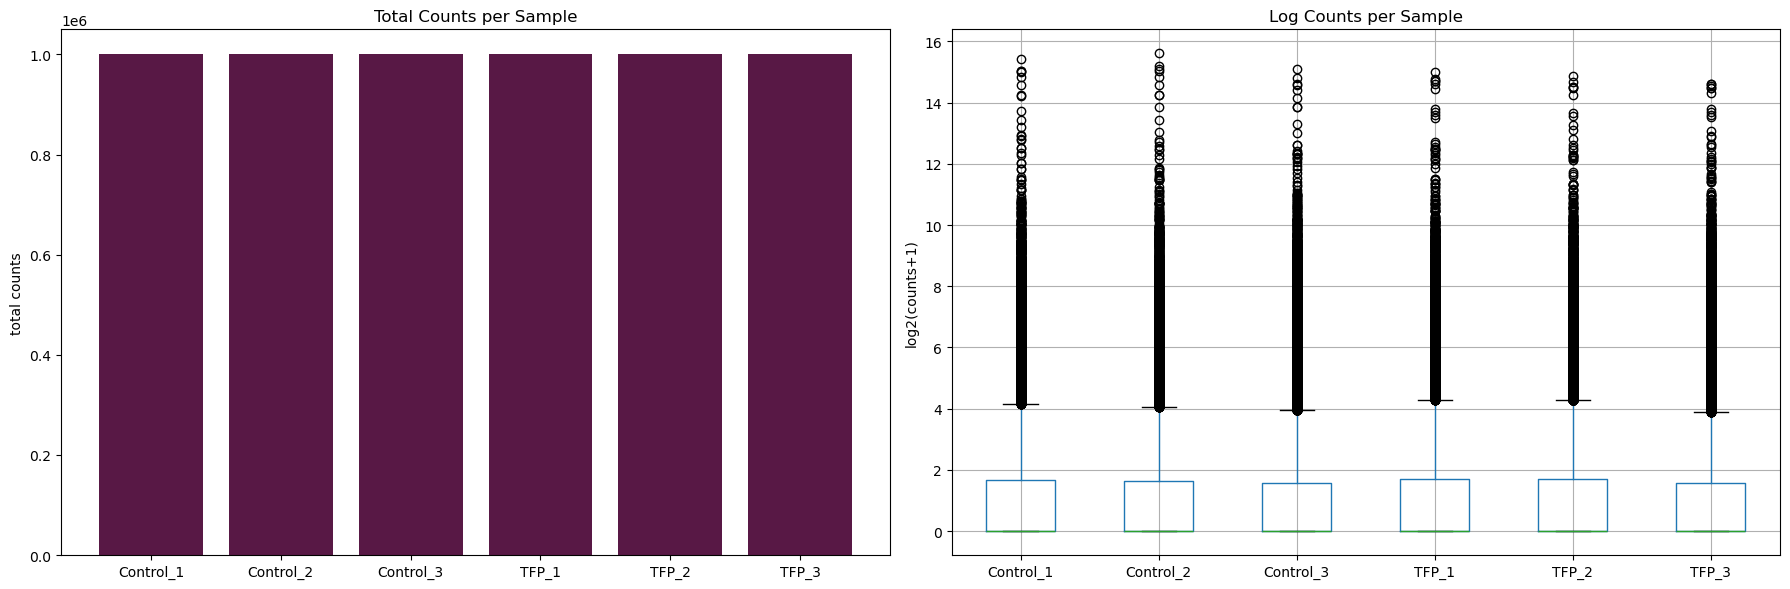

In [11]:
# comparing total counts and log counts across samples 

expression_values=['Control_1','Control_2','Control_3','TFP_1' ,'TFP_2', 'TFP_3']
df_exp = df[expression_values]  #dataframe containing only the expression values

total_counts = df_exp[expression_values].sum(axis=0)
log_counts = df_exp.apply(lambda x: np.log2(x+1)) 

fig, axes = plt.subplots( 1, 2, figsize=(18,6))
#total
axes[0].bar(df_exp.columns, total_counts, color='#581845')
axes[0].set_ylabel('total counts')
axes[0].set_title('Total Counts per Sample')
#log
log_counts.boxplot(ax=axes[1])
axes[1].set_ylabel('log2(counts+1)')
axes[1].set_title('Log Counts per Sample')

plt.tight_layout()
plt.show()

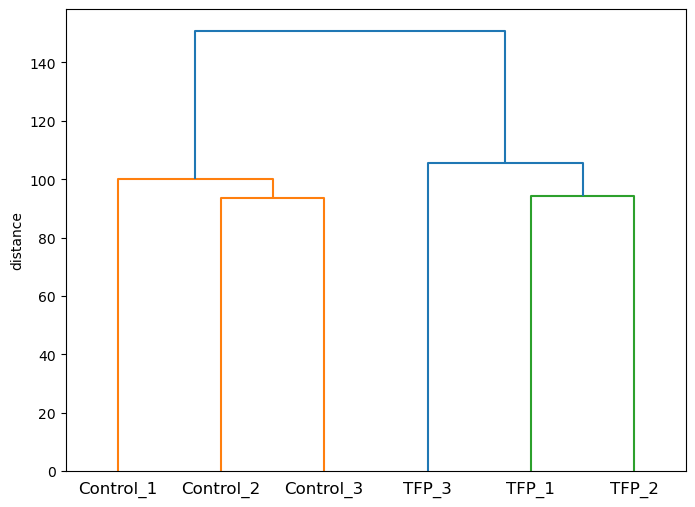

In [12]:
#hierarchial clustering
h_clustering = linkage(log_counts.T, 'ward')
plt.figure(figsize=(8,6))
dendrogram(h_clustering, labels=df_exp.columns)
plt.ylabel('distance')
plt.show()

we can observe how the control samples are all clustered on the left and the treated samples all on the right: this is a good sign as it suggests biological variation between the two groups

### filtering
the file we are working with is already normalized as Transcripts Per Million, thus we need to establish a TPm treshold to filter relevant genes.

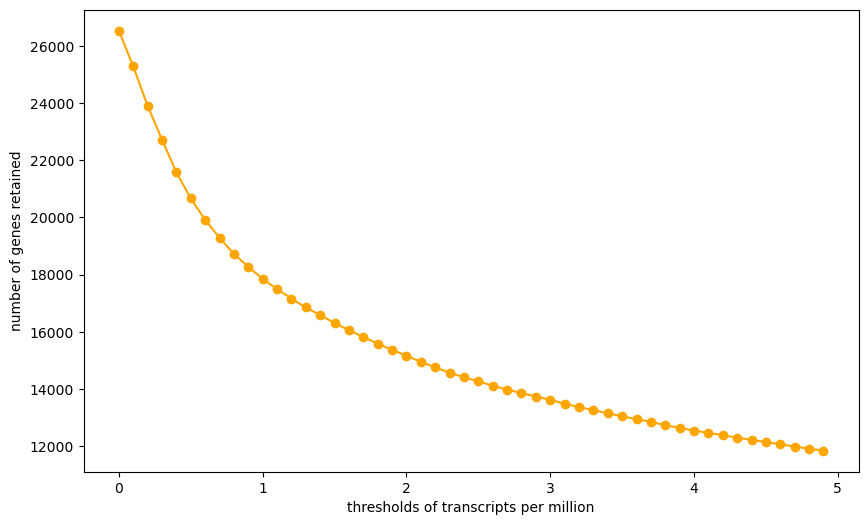

In [13]:
#visualizing genes retained at different tpm tresholds to get an idea on where to place a threshold
def genes_retained_tpm(df, min_samples=3):

    genes_retained=[]
    thresholds = np.arange(0,5,0.1)

    for min_tpm in thresholds:
        mask = (df > min_tpm).sum(axis=1) >= min_samples
        genes_retained.append(mask.sum())

    plt.figure(figsize=(10,6))
    plt.plot(thresholds, genes_retained, marker='o', color='orange')
    plt.ylabel('number of genes retained')
    plt.xlabel('thresholds of transcripts per million')

genes_retained_tpm(df_exp)

after testing out some ranges I chose a thrshold of 0.75

In [14]:
def filter_and_normalize(df, min_tpm=1, min_samples=3):
    #filters TPM gene expression data 
    mask = (df > min_tpm).sum(axis=1) >= min_samples
    filtered_df = df[mask]

    #computing geometric means of non zero values for each gene 
    gm = filtered_df.apply(lambda row: np.exp(np.log(row[row > 0]).mean()), axis=1)
    #calculating size factors 
    sf = filtered_df.div(gm, axis=0).median(axis=0)
    #normalizing by dividing each gene for its size factor 
    normalized_data = filtered_df.div( sf, axis=1)

    #return a dataframe with normalized values 
    return pd.DataFrame(normalized_data, index= filtered_df.index, columns= filtered_df.columns)

#function call on df_exp
df_norm = filter_and_normalize(df_exp, min_tpm=0.75)

### differential expression analysis
pairwise analysis between individual control and experimental samples.


In [15]:
results = []

for gene in df_norm.index:
    #extract control group data for current gene 
    control = df_norm.loc[gene , ['Control_1','Control_2','Control_3']]
    #extract TFP treated patients data for current gene 
    treated = df_norm.loc[gene, ['TFP_1','TFP_2','TFP_3']]

    #mean expressions
    mean_control = np.mean(control)
    mean_treated = np.mean(treated)

    #computing the log2 fold change and adding 1 for handling zero values
    log2fc=np.log2((mean_treated +1)/(mean_control +1))

    #performing a t test and finding p_values 
    t_stat, p_val = ttest_ind(control, treated)

    #appending findings for the current gene to the resutls list as a dictionary 
    results.append({'gene': gene, 'log2fc': log2fc, 't_stat': t_stat, 'p_val': p_val})

results_df = pd.DataFrame(results)

#conversion of p_values to numeric values, coercing errors to NaN if conversion fails
results_df['p_val'] = pd.to_numeric(results_df['p_val'], errors='coerce')
results_df = results_df.dropna(subset=['p_val'])

#applying Benjamini-Hochberg correction method to p_values (see link below)
results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]  

#calculating absolute log2fc to detect both up and down regulated genes 
results_df['abs_log2fc'] = results_df['log2fc'].abs()

deg = results_df[(results_df['p_adj']<0.05) & (results_df['abs_log2fc'] > 1 )]



/home/thomas/miniconda3/envs/rnaseq/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/home/thomas/miniconda3/envs/rnaseq/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [16]:
#exploring deg 
print(deg.shape)
deg.describe()

(159, 6)


,log2fc,p_val,p_adj,abs_log2fc
count,159.000000,159.000000,159.000000,159.000000
mean,-0.122665,0.000509,0.038571,1.717664
std,1.846512,0.000373,0.007698,0.675060
min,-3.967928,0.000002,0.017839,1.002543
25%,-1.639790,0.000153,0.031648,1.245140
50%,1.012799,0.000523,0.041804,1.503853
75%,1.434251,0.000796,0.045533,1.985495
max,4.144995,0.001267,0.049503,4.144995


why we use log2 fold change : https://en.wikipedia.org/wiki/Fold_change

the benjamini-hochberg correction : https://bioinfo.cd-genomics.com/resource-p-values-vs-fdr-adjusted-p-values.html

### visualizing results 

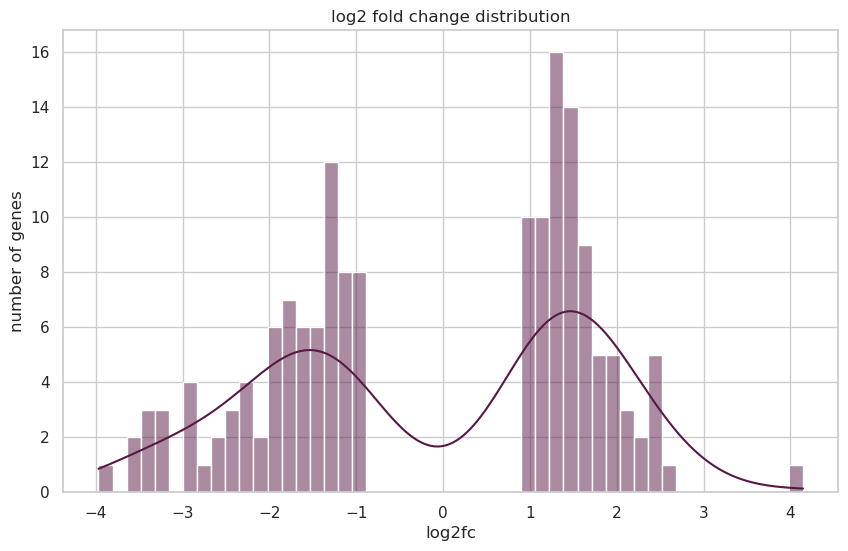

In [17]:
#distribution of log2fc
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
sns.histplot(deg['log2fc'], bins=50, kde=True, color='#581845' )
plt.title('log2 fold change distribution')
plt.ylabel('number of genes')
plt.xlabel('log2fc')
plt.show()

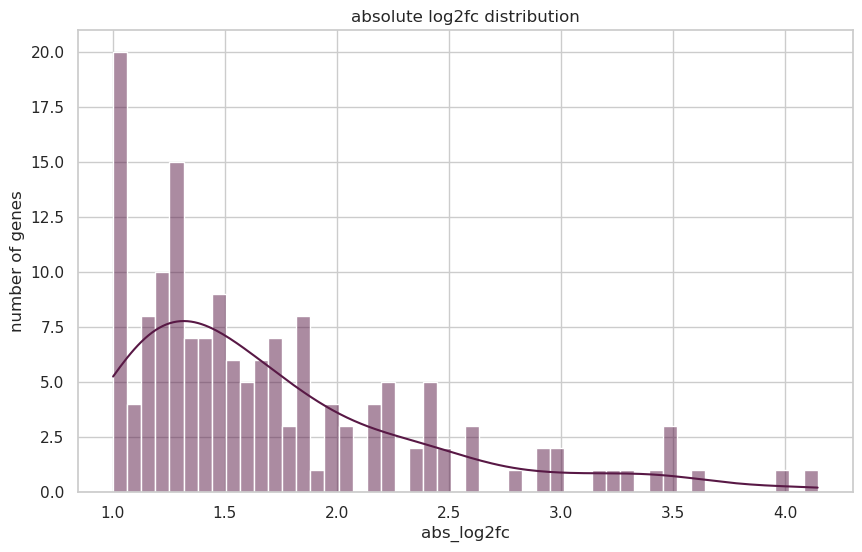

In [18]:
#distribution of log2fc
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
sns.histplot(deg['abs_log2fc'], bins=50, kde=True, color='#581845' )
plt.title('absolute log2fc distribution')
plt.ylabel('number of genes')
plt.xlabel('abs_log2fc')
plt.show()


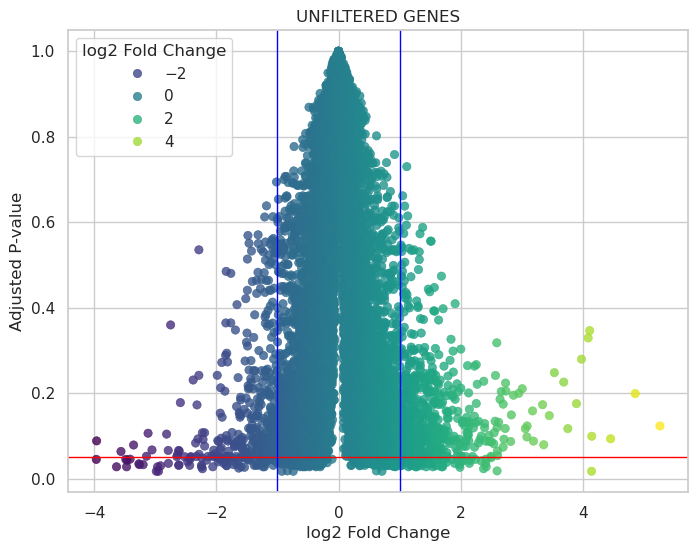

In [19]:
#unfiltered data
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.8, edgecolor=None)
plt.axhline(y=0.05, color='red', linestyle='-', linewidth=1)
plt.axvline(x=1, color='blue', linestyle='-', linewidth=1)
plt.axvline(x=-1, color='blue', linestyle='-', linewidth=1)
plt.xlabel('log2 Fold Change')
plt.ylabel('Adjusted P-value')
plt.title('UNFILTERED GENES')
plt.legend(title='log2 Fold Change', loc='upper left')
plt.show()

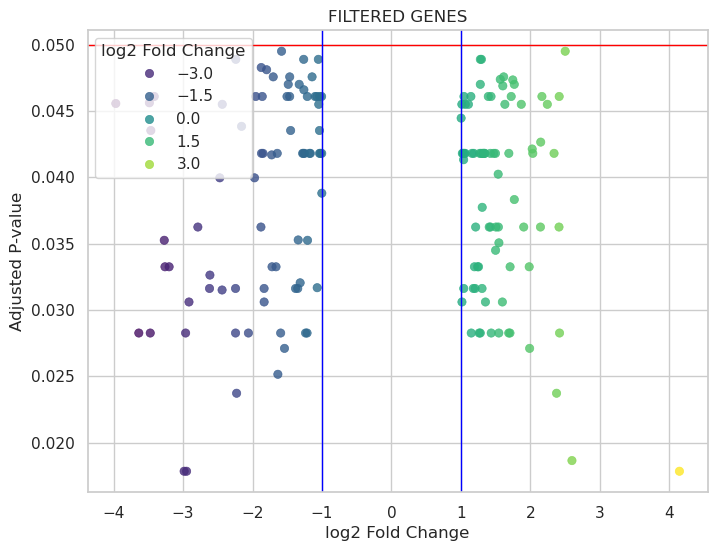

In [20]:
#filtered data
plt.figure(figsize=(8, 6))
sns.scatterplot(data=deg, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.8, edgecolor=None)
plt.axhline(y=0.05, color='red', linestyle='-', linewidth=1)
plt.axvline(x=1, color='blue', linestyle='-', linewidth=1)
plt.axvline(x=-1, color='blue', linestyle='-', linewidth=1)
plt.xlabel('log2 Fold Change')
plt.ylabel('Adjusted P-value')
plt.title('FILTERED GENES')
plt.legend(title='log2 Fold Change', loc='upper left')
plt.show()

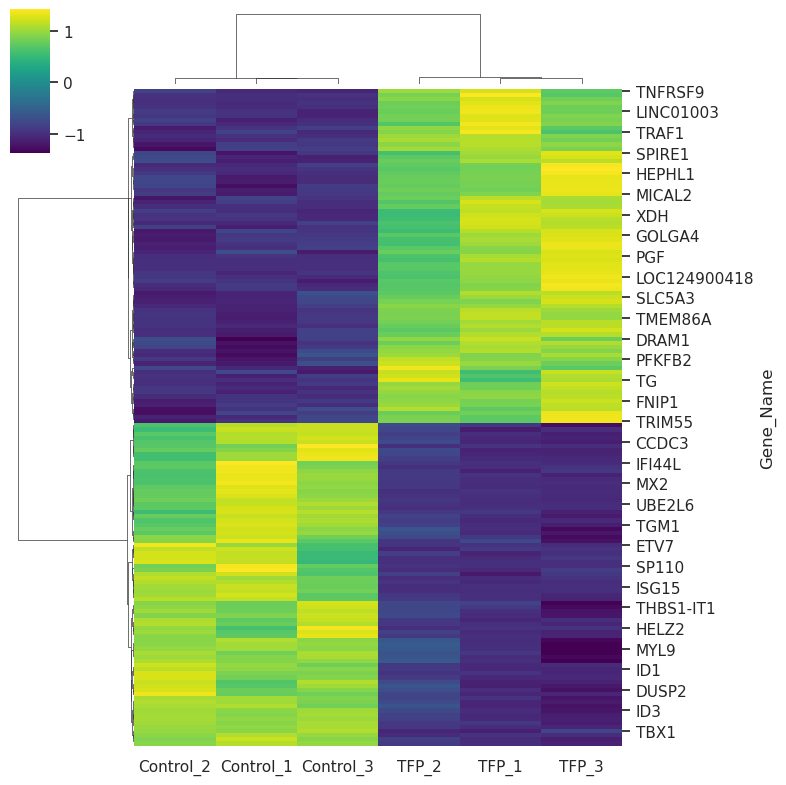

In [21]:
#heatmap
significant_genes = deg['gene'].tolist()
sig_df = df_norm.loc[significant_genes]
scaler = StandardScaler()
#transposing, fitting (computing mean and sd) and transforming (for each feature f : (f-mean)/sd)
sig_df_scaled = pd.DataFrame(scaler.fit_transform(sig_df.T).T , index=sig_df.index, columns = sig_df.columns)
sns.clustermap(sig_df_scaled, method='ward', cmap='viridis', metric='euclidean', figsize=(8,8), dendrogram_ratio=(0.2,0.1))
plt.show()

### functional enrichment analysis 
trying to identify and interpret overrepresented biological functions and pathways, helping us to make sense of the mechanism of action of Trifluoperazine (TFP)



In [30]:
# extract the list of gene names for differentially expressed genes (DEGs)
gene_list = deg['gene'].tolist() 
enrichment_results = gp.enrichr(gene_list, gene_sets=['KEGG_2016'], organism='human')
enrichment_df = enrichment_results.results
print(enrichment_df.shape)
enrichment_df.head(5)

(175, 10)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,TNF signaling pathway Homo sapiens hsa04668,7/110,0.000028,0.004932,0,0,8.825115,92.458179,CSF2;CCL5;TNFAIP3;TRAF1;TNFRSF1B;CREB5;BIRC3
1,KEGG_2016,Lysosome Homo sapiens hsa04142,7/123,0.000058,0.005050,0,0,7.830932,76.429254,MANBA;NPC2;FUCA1;NEU1;SLC17A5;ACP5;TPP1
2,KEGG_2016,Other glycan degradation Homo sapiens hsa00511,3/18,0.000369,0.015457,0,0,25.417949,200.953942,MANBA;FUCA1;NEU1
3,KEGG_2016,TGF-beta signaling pathway Homo sapiens hsa04350,5/84,0.000555,0.015457,0,0,8.121815,60.883501,ID2;ID1;ID3;SMAD6;SMAD7
4,KEGG_2016,Amino sugar and nucleotide sugar metabolism Ho...,4/48,0.000570,0.015457,0,0,11.611144,86.733629,GNPDA1;HKDC1;UAP1L1;HK2


/tmp/ipykernel_1149/2666613417.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_combined_score, x='Combined Score', y='Term', palette='viridis')


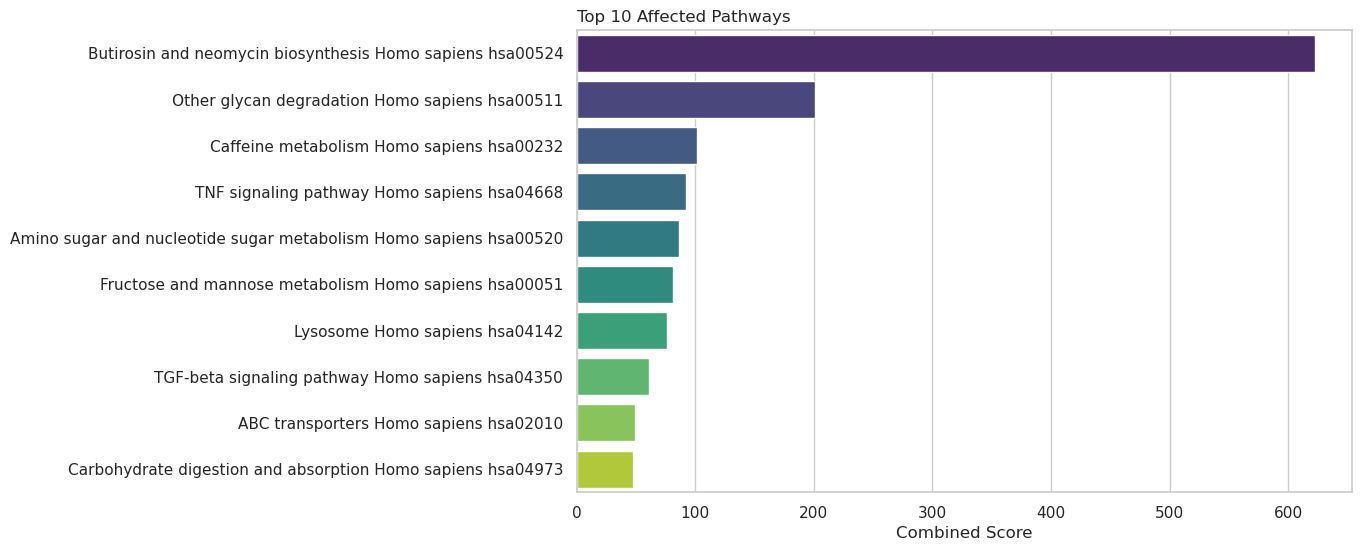

In [31]:
#ordering by combined score and picking top 10
top_10_combined_score = enrichment_df.sort_values(by='Combined Score', ascending=False).head(10)
#print(top_10_combined_score)
#barplot
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_combined_score, x='Combined Score', y='Term', palette='viridis')
plt.title('Top 10 Affected Pathways', loc='left')
plt.ylabel('')
plt.show()

you can find more details about the combined score in the documentation of enrichr : https://maayanlab.cloud/Enrichr/help#background&q=4ù
(bottom of the webpage)
